# 04 — Backtest + Monte Carlo

Goal: stress‑test hypotheses about `gabagool22` using only what we have in ClickHouse.

This notebook:
- Uses **settlement PnL** (profit/loss at market resolution).
- Aggregates trades into short **units** (market + time bucket) to avoid treating split orders as independent.
- Runs a **circular block bootstrap** over time‑ordered unit PnL to estimate distributions of total PnL + drawdown.
- Compares execution‑price scenarios (actual vs mid vs exec‑proxy), plus explicit upper/lower bounds.

Limitations:
- Not a full execution simulator (no queue position / fill probability).
- If we later observe SELL trades / early exits, we should switch to a proper position ledger.


In [1]:
username = "gabagool22"

# If None, auto-pick latest snapshot for this username.
snapshot_dir = None

# Execution-price scenarios to compare.
# - actual: observed trade price
# - mid: entry at mid (benchmark)
# - exec_proxy: entry based on exec_type proxy (maker/taker/inside)
# - all_maker/all_taker: explicit upper/lower bounds (ignore fill probability)
scenarios = ["actual", "exec_proxy", "mid", "all_maker", "all_taker"]

# Unit bucketing:
# If the snapshot already has a `bucket` column from 02_*, we use it.
# Otherwise we compute it with this window.
unit_bucket_seconds = 10

# Bootstrap settings (increase later if needed).
bootstrap_iters = 20_000
block_len = 50

# Only use trades with settle_price available.
only_resolved = True


In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "research" / "snapshot.py").exists():
            return p
    raise RuntimeError(
        "Cannot locate repo root (expected to find `research/snapshot.py`). "
        "Start Jupyter from the repo root or set REPO_ROOT=/path/to/polybot."
    )


repo_root_env = os.getenv("REPO_ROOT")
repo_root = Path(repo_root_env) if repo_root_env else _find_repo_root(Path.cwd())
sys.path.insert(0, str(repo_root / "research"))

from research.backtest import (
    block_bootstrap,
    compute_trade_cost,
    compute_trade_pnl,
    load_features,
    summarize_pnl,
)


Matplotlib is building the font cache; this may take a moment.


In [3]:
loaded = load_features(username=username, snapshot_dir=snapshot_dir)
df = loaded.features.copy()

df["ts"] = pd.to_datetime(df["ts"], errors="coerce", utc=True)
df["end_date"] = pd.to_datetime(df.get("end_date"), errors="coerce", utc=True)

if "bucket" not in df.columns:
    df["bucket"] = df["ts"].dt.floor(f"{int(unit_bucket_seconds)}s")

df["settle_price"] = pd.to_numeric(df.get("settle_price"), errors="coerce")
df["realized_pnl"] = pd.to_numeric(df.get("realized_pnl"), errors="coerce")
df["tob_known"] = pd.to_numeric(df.get("tob_known"), errors="coerce").fillna(0).astype(int)

resolved = df.copy()
if only_resolved:
    resolved = resolved[resolved["settle_price"].notna()].copy()

print("snapshot:", loaded.snapshot_path)
print("rows:", len(df), "resolved:", len(resolved), f"resolved_pct={len(resolved)/len(df):.1%}")
print("tob_known (resolved):", resolved["tob_known"].mean())

resolved[["ts", "market_slug", "asset", "outcome", "price", "size", "settle_price", "realized_pnl", "tob_known"]].head()


snapshot: /Users/antoniostano/programming/polybot/research/data/snapshots/gabagool22-20251214T200720+0000
rows: 7221 resolved: 4882 resolved_pct=67.6%
tob_known (resolved): 0.8424825891028267


,ts,market_slug,asset,outcome,price,size,settle_price,realized_pnl,tob_known
48,2025-12-14 18:30:33+00:00,btc-updown-15m-1765737000,BTC,Down,0.39,20.00,0.0,-7.8000,1
49,2025-12-14 18:30:33+00:00,btc-updown-15m-1765737000,BTC,Down,0.39,20.00,0.0,-7.8000,1
50,2025-12-14 18:30:47+00:00,btc-updown-15m-1765737000,BTC,Down,0.29,9.06,0.0,-2.6274,1
51,2025-12-14 18:31:05+00:00,btc-updown-15m-1765737000,BTC,Down,0.30,20.00,0.0,-6.0000,1
52,2025-12-14 18:31:05+00:00,btc-updown-15m-1765737000,BTC,Down,0.30,20.00,0.0,-6.0000,1


## Scenario meaning

- `actual`: what the data says happened (uses `realized_pnl` when present).
- `mid`: benchmark vs TOB mid.
- `exec_proxy`: uses `exec_type` proxy:
  - BUY: `MAKER_LIKE`→bid, `TAKER_LIKE`→ask, `INSIDE`→mid; else uses actual.
  - SELL: `MAKER_LIKE`→ask, `TAKER_LIKE`→bid, `INSIDE`→mid; else uses actual.
- `all_maker` / `all_taker`: **bounds only** (ignore fill probability and queue).

We run each scenario in two modes:

- **all_resolved**: keep all resolved trades; scenarios fall back to actual price when TOB is missing.
- **tob_known_only**: only use trades where TOB is known; scenarios do not fall back to actual.


In [4]:
def run_scenario(frame: pd.DataFrame, scenario: str, *, fallback_to_actual: bool) -> dict:
    pnl = compute_trade_pnl(frame, scenario=scenario, fallback_to_actual=fallback_to_actual)
    cost = compute_trade_cost(frame, scenario=scenario, fallback_to_actual=fallback_to_actual)
    tmp = frame.assign(pnl=pnl, cost=cost)

    # Drop rows where pnl is unknown (unresolved or missing required TOB fields in strict mode).
    tmp = tmp[tmp["pnl"].notna()].copy()

    # PnL is realized at resolution time; if end_date is missing, fall back to trade ts.
    tmp["pnl_ts"] = tmp["end_date"].where(tmp["end_date"].notna(), tmp["ts"])

    unit_cols = ["market_slug", "bucket"]
    units = (
        tmp.groupby(unit_cols, dropna=False, as_index=False)
        .agg(
            pnl=("pnl", "sum"),
            cost=("cost", "sum"),
            pnl_ts=("pnl_ts", "max"),
            trades=("pnl", "size"),
        )
        .sort_values("pnl_ts")
        .reset_index(drop=True)
    )
    units["roi"] = units["pnl"] / units["cost"].replace(0, np.nan)

    pnl_arr = pd.to_numeric(units["pnl"], errors="coerce").to_numpy()
    summary = summarize_pnl(pnl_arr)
    win_rate = float(np.mean(pnl_arr[np.isfinite(pnl_arr)] > 0)) if np.isfinite(pnl_arr).any() else float("nan")
    boot = block_bootstrap(pnl_arr, iters=bootstrap_iters, block_len=block_len)

    return {
        "scenario": scenario,
        "units": int(summary.get("n", 0)),
        "trades": int(len(tmp)),
        "pnl_sum": float(summary.get("sum", 0)),
        "pnl_mean": float(summary.get("mean", float("nan"))),
        "pnl_std": float(summary.get("std", float("nan"))),
        "win_rate": win_rate,
        "max_drawdown": float(summary.get("max_drawdown", float("nan"))),
        "boot_total_p50": float(boot.get("total_pnl", {}).get("p50", float("nan"))),
        "boot_total_p05": float(boot.get("total_pnl", {}).get("p05", float("nan"))),
        "boot_total_p95": float(boot.get("total_pnl", {}).get("p95", float("nan"))),
        "boot_dd_p50": float(boot.get("max_drawdown", {}).get("p50", float("nan"))),
        "units_df": units,
    }


def run_all(frame: pd.DataFrame, *, fallback_to_actual: bool, label: str) -> tuple[pd.DataFrame, dict[str, pd.DataFrame]]:
    rows = []
    units_by_scenario: dict[str, pd.DataFrame] = {}
    for scenario in scenarios:
        result = run_scenario(frame, scenario, fallback_to_actual=fallback_to_actual)
        units_by_scenario[scenario] = result.pop("units_df")
        result["mode"] = label
        result["fallback_to_actual"] = fallback_to_actual
        rows.append(result)

    summary_df = pd.DataFrame(rows).sort_values("pnl_sum", ascending=False)
    return summary_df, units_by_scenario


In [5]:
# Mode A: use all resolved trades; scenarios fall back to actual when TOB is missing.
summary_all, units_all = run_all(resolved, fallback_to_actual=True, label="all_resolved")
summary_all


,scenario,units,trades,pnl_sum,pnl_mean,pnl_std,win_rate,max_drawdown,boot_total_p50,boot_total_p05,boot_total_p95,boot_dd_p50,mode,fallback_to_actual
3,all_maker,1587,4882,8331.25338,5.249687,25.575951,0.531191,443.102590,8223.642857,4499.790807,12543.650597,361.926905,all_resolved,True
0,actual,1587,4882,667.01358,0.420298,22.659297,0.511027,513.639500,666.213293,-425.627902,1742.560329,564.666607,all_resolved,True
1,exec_proxy,1587,4882,122.19448,0.076997,21.684530,0.508507,548.319700,132.500705,-939.802716,1154.970186,694.240080,all_resolved,True
2,mid,1587,4882,89.10513,0.056147,21.668266,0.509137,554.617265,100.561913,-971.879448,1123.065486,705.134015,all_resolved,True
4,all_taker,1587,4882,-8193.46792,-5.162866,25.118302,0.485192,8603.575270,-8097.151180,-12340.715967,-4275.915792,8277.498970,all_resolved,True


In [6]:
# Mode B (TOB missingness stress): only trades where TOB is known; no fallback.
resolved_tob = resolved[resolved["tob_known"] == 1].copy()
summary_tob, units_tob = run_all(resolved_tob, fallback_to_actual=False, label="tob_known_only")
summary_tob


,scenario,units,trades,pnl_sum,pnl_mean,pnl_std,win_rate,max_drawdown,boot_total_p50,boot_total_p05,boot_total_p95,boot_dd_p50,mode,fallback_to_actual
3,all_maker,1330,4113,7986.89708,6.005186,26.398392,0.529323,436.667765,7865.032390,4161.907998,12066.699899,411.134840,tob_known_only,False
0,actual,1330,4113,376.06668,0.282757,23.161000,0.502256,411.071140,384.541288,-687.494551,1394.000765,655.289047,tob_known_only,False
1,exec_proxy,1330,4113,-168.75242,-0.126882,22.016012,0.499248,547.648455,-154.008197,-1220.792197,839.276533,823.110595,tob_known_only,False
2,mid,1330,4113,-201.84177,-0.151761,21.996681,0.500000,562.429855,-186.587670,-1255.048920,806.919409,837.239343,tob_known_only,False
4,all_taker,1330,4113,-8390.58062,-6.308707,25.747849,0.470677,8460.749920,-8267.868142,-12276.862173,-4731.568646,8408.427973,tob_known_only,False


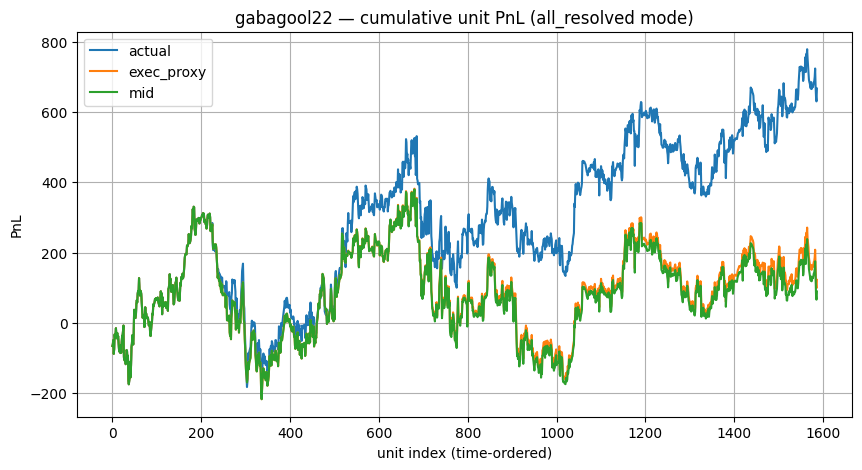

In [7]:
# Equity curves (unit PnL) for a few scenarios.
to_plot = [s for s in ["actual", "exec_proxy", "mid"] if s in units_all]
plt.figure(figsize=(10, 5))
for s in to_plot:
    u = units_all[s]
    pnl = pd.to_numeric(u["pnl"], errors="coerce").fillna(0.0)
    equity = pnl.cumsum()
    plt.plot(equity.to_numpy(), label=s)
plt.title(f"{username} — cumulative unit PnL (all_resolved mode)")
plt.xlabel("unit index (time-ordered)")
plt.ylabel("PnL")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Optional: regime breakdown (actual PnL).
if "regime" in resolved.columns:
    tmp = resolved.copy()
    tmp["pnl"] = compute_trade_pnl(tmp, scenario="actual", fallback_to_actual=True)
    tmp = tmp[tmp["pnl"].notna()].copy()
    g = tmp.groupby("regime")["pnl"]
    pd.DataFrame(
        {
            "trades": g.size(),
            "pnl_sum": g.sum(),
            "pnl_mean": g.mean(),
            "win_rate": g.apply(lambda s: (s > 0).mean()),
        }
    ).sort_values("pnl_sum", ascending=False)
else:
    print("No regime column found.")


In [9]:
# Save summaries next to the snapshot for reproducibility.
out_dir = loaded.snapshot_path
summary_all_path = out_dir / "backtest_summary_all_resolved.csv"
summary_tob_path = out_dir / "backtest_summary_tob_known_only.csv"

summary_all.to_csv(summary_all_path, index=False)
summary_tob.to_csv(summary_tob_path, index=False)

print("wrote:", summary_all_path)
print("wrote:", summary_tob_path)


wrote: /Users/antoniostano/programming/polybot/research/data/snapshots/gabagool22-20251214T200720+0000/backtest_summary_all_resolved.csv
wrote: /Users/antoniostano/programming/polybot/research/data/snapshots/gabagool22-20251214T200720+0000/backtest_summary_tob_known_only.csv
